# Reduced Gravity

## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, OceanographicUtilities, Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

## Selecting area and loading initial- and boundary conditions

#### Plotting utils

In [4]:
from IPython.display import clear_output
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
from gpuocean.utils import PlotHelper
from gpuocean.utils.NetCDFInitialization import depth_integration

def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-5, h_max=5, 
                 uv_min=-0.3, uv_max=0.3,
                 calc_uv = False, 
                 add_extra=False,
                 reduced_gravity_interface=None,
                 ax=None, sp=None):


    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000
   
    hu_label, hv_label = "$hu$", "$hv$"
    if calc_uv:
        """plotting actually u and v"""
        if reduced_gravity_interface is None or reduced_gravity_interface == 0.0:
            hu = hu/(h+eta)
            hv = hv/(h+eta)
        else:
            hu = hu/(reduced_gravity_interface+eta)
            hv = hv/(reduced_gravity_interface+eta)
        uv_min = -0.3
        uv_max = +0.3
        hu_label, hv_label = "$u$", "$v$"

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
  

        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, 
                            vmin=uv_min, vmax=uv_max, 
                            extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title(hu_label)



        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title(hv_label)
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, x0=0, x1=-1, y0=0, y1=-1, reduced_gravity_interface=None, **kwargs):
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))

    try:
        ncfile = Dataset(filename)
        try:
            x = ncfile.variables['x'][:]
        except:
            x = ncfile.variables['X'][x0:x1]
        try:
            y = ncfile.variables['y'][:]
        except:
            y = ncfile.variables['Y'][y0:y1]
        t = ncfile.variables['time'][:]

        try:
            H_m = ncfile.variables['Hm'][:,:]
        except:
            H_m = ncfile.variables['h'][y0:y1,x0:x1]
        try:
            eta = ncfile.variables['eta'][:,:,:]
        except:
            eta = ncfile.variables['zeta'][:,y0:y1,x0:x1]
        try:
            hu = ncfile.variables['hu'][:,:,:]
            calc_uv = True
        except:
            if reduced_gravity_interface is None:
                hu = ncfile.variables['ubar'][:,y0:y1,x0:x1]
                calc_uv = False
            else:
                if reduced_gravity_interface > 0.0:
                    hu = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hu[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "u", timestep_index=t_idx)
                    calc_uv = True
                else:
                    hu = ncfile.variables['u'][:,0,y0:y1,x0:x1]
                    calc_uv = False
        try:
            hv = ncfile.variables['hv'][:,:,:]
        except:
            if reduced_gravity_interface is None:
                hv = ncfile.variables['vbar'][:,y0:y1,x0:x1]
            else:
                if reduced_gravity_interface > 0.0:
                    hv = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hv[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "v", timestep_index=t_idx)
                else:
                    hv = ncfile.variables['v'][:,0,y0:y1,x0:x1]
                    
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], filename,
                              calc_uv=calc_uv,
                              reduced_gravity_interface=reduced_gravity_interface,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], filename,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                        (1-s)*eta[j] + s*eta[k], 
                        (1-s)*hu[j]  + s*hu[k], 
                        (1-s)*hv[j]  + s*hv[k], 
                        H_m+(1-s)*eta[j] + s*eta[k], 
                        dx, dy, 
                        t_now, filename,
                        calc_uv=calc_uv,
                        reduced_gravity_interface=reduced_gravity_interface,
                        **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        #print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=250)
    plt.close(fig)
    
    return anim


## Simulating upper layer

In [5]:
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

casename = 'lofoten'

case_info = NetCDFInitialization.getCaseLocation(casename)
case_info.pop("name")

'lofoten'

In [6]:
upper_data_args = NetCDFInitialization.getInitialConditions(source_url,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], download_data=False, reduced_gravity_interface=25.0)

Cut the bathymetry: no reconstruction!
Depth integration with trapeziodal rule, ignoring eta
Reduce gravity (fixed value used)
Depth integration with trapeziodal rule, ignoring eta


In [7]:
full_data_args = NetCDFInitialization.getInitialConditions(source_url,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], download_data=False)

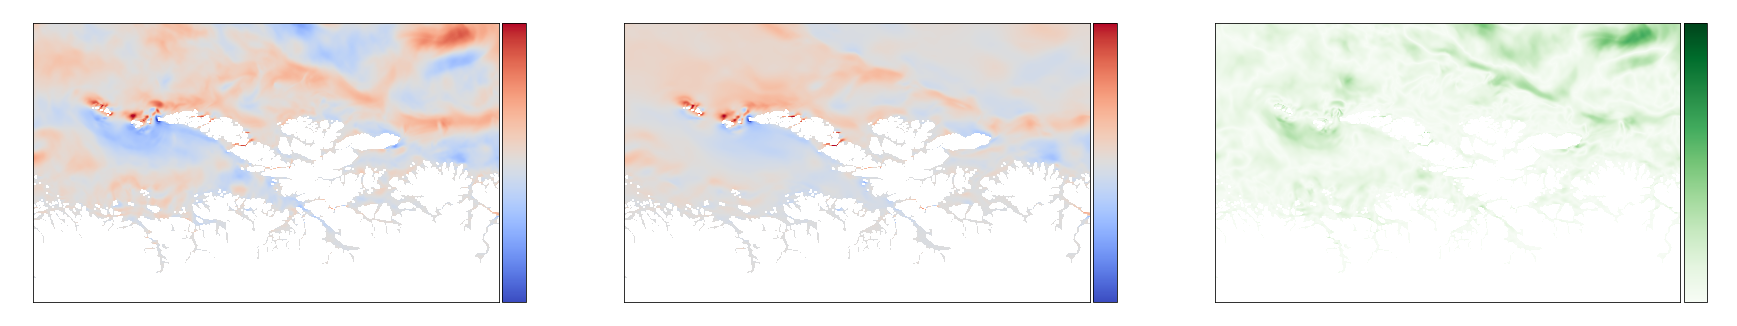

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,3,figsize=(30,12))

upper_u0 = upper_data_args["hu0"]/(OceanographicUtilities.intersectionsToMidpoints(upper_data_args["H"]) + upper_data_args["eta0"])
im0 = axs[0].imshow(upper_u0, origin="lower", cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
axs[0].set_title("u (upper layer)")

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax)

full_u0 = full_data_args["hu0"]/(OceanographicUtilities.intersectionsToMidpoints(full_data_args["H"]) + full_data_args["eta0"])
axs[1].imshow(full_u0, origin="lower", cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
axs[1].set_title("u (full)")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax)

im2 = axs[2].imshow(abs(full_u0 - upper_u0), origin="lower", cmap="Greens", vmin=0, vmax=1)
axs[2].set_title("|u (full) - u (upper layer)|")

divider = make_axes_locatable(axs[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax)

In [9]:
import copy 
data_args = copy.deepcopy(upper_data_args)

In [10]:
#data_args["H"][data_args["H"]<25.0] = 25.0

For the initialisation of the simulation as well as for the boundary conditions, we use
- $\eta - \Eta$
- $h(u-U)$
- $h(v-V)$

Where capitals denote the full-depth integrated variables and minuscles the upper layer-integrated quantities 

In [11]:
import netCDF4 
nc = netCDF4.Dataset(source_url)

locals().update(case_info)

In [12]:
# Set initial conditions
upper_eta0 = upper_data_args["eta0"]
full_eta0  = full_data_args["eta0"]
data_args["eta0"] = upper_eta0 - full_eta0

full_H  = np.ma.array(nc['h'][y0:y1, x0:x1], mask=full_eta0.mask.copy())
upper_H = np.ma.minimum(full_H, 25.0)

upper_u0 = upper_data_args["hu0"]/(upper_H + upper_data_args["eta0"])
full_u0  = full_data_args["hu0"]/(full_H + full_data_args["eta0"])
data_args["hu0"]  = upper_H*(upper_u0 - full_u0)

upper_v0 = upper_data_args["hv0"]/(upper_H + upper_data_args["eta0"])
full_v0  = full_data_args["hv0"]/(full_H + full_data_args["eta0"])
data_args["hv0"]  = upper_H*(upper_v0 - full_v0)

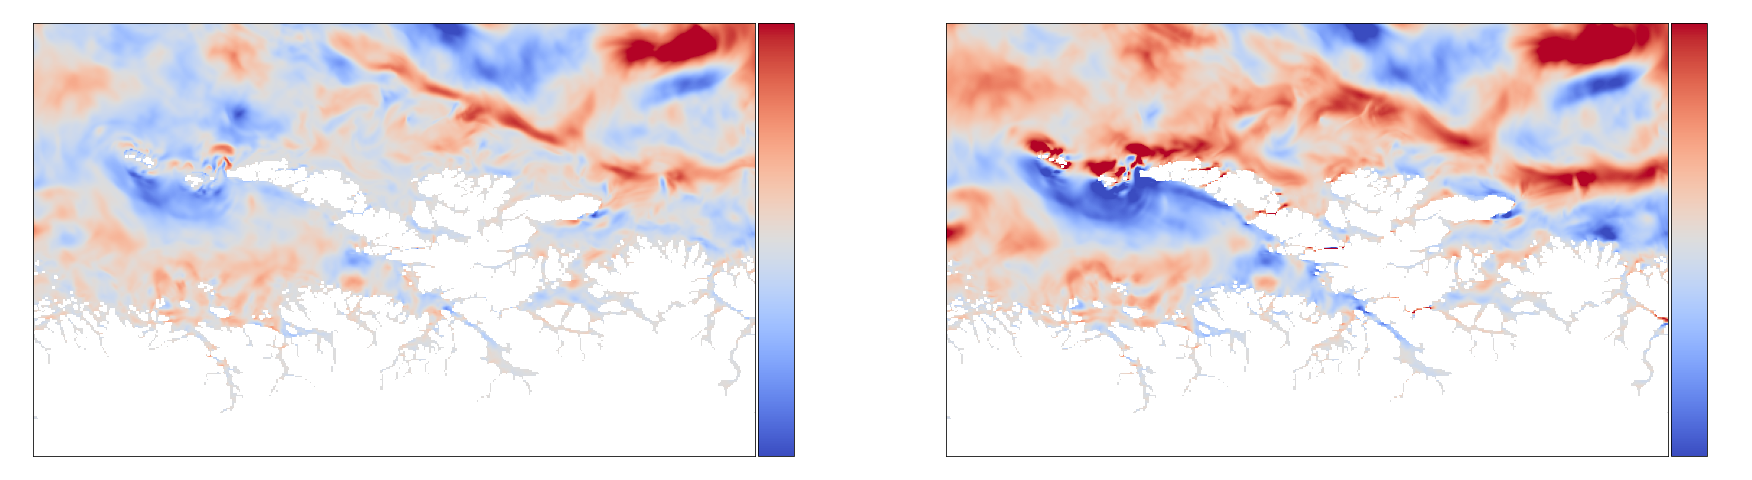

In [13]:
fig, axs = plt.subplots(1,2,figsize=(30,12))

im0 = axs[0].imshow(data_args["hu0"], origin="lower", cmap=plt.cm.coolwarm, vmin=-10, vmax=10)
axs[0].set_title("hu0 upper for init")

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax)

axs[1].imshow(upper_data_args["hu0"], origin="lower", cmap=plt.cm.coolwarm, vmin=-10, vmax=10)
axs[1].set_title("hu0 upper from file")

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax)



In [14]:
# preparing boundary condition data
full_eta = nc['zeta'][:, y0:y1, x0:x1]
# full_h = full_eta + full_H
full_u = nc['ubar'][:, y0:y1, x0:x1]
full_v = nc['vbar'][:, y0:y1, x0:x1]

In [15]:
from gpuocean.utils.NetCDFInitialization import depth_integration

upper_eta = nc['zeta'][:, y0:y1, x0:x1]
upper_h = upper_H + upper_eta

upper_hu = np.zeros_like(upper_eta)
for t in range(upper_hu.shape[0]):
    upper_hu[t] = depth_integration(nc, 25.0, x0, x1, y0, y1, "u", t)
upper_u = upper_hu / upper_h

upper_hv = np.zeros_like(upper_eta)
for t in range(upper_hu.shape[0]):
    upper_hv[t] = depth_integration(nc, 25.0, x0, x1, y0, y1, "v", t)
upper_v = upper_hv / upper_h

data_eta = upper_eta - full_eta
data_hu  = upper_h * (upper_u - full_u)
data_hv  = upper_h * (upper_v - full_v)

data_eta = data_eta.filled(0)
data_hu  = data_hu.filled(0)
data_hv  = data_hv.filled(0)

In [16]:
data_args["boundary_conditions_data"].north.h  = np.float32(data_eta[:,-1,:])
data_args["boundary_conditions_data"].north.hu = np.float32(data_hu[:,-1,:])
data_args["boundary_conditions_data"].north.hv = np.float32(data_hv[:,-1,:])

data_args["boundary_conditions_data"].south.h  = np.float32(data_eta[:,0,:])
data_args["boundary_conditions_data"].south.hu = np.float32(data_hu[:,0,:])
data_args["boundary_conditions_data"].south.hv = np.float32(data_hv[:,0,:])

data_args["boundary_conditions_data"].west.h   = np.float32(data_eta[:,:,0])
data_args["boundary_conditions_data"].west.hu  = np.float32(data_hu[:,:,0])
data_args["boundary_conditions_data"].west.hv  = np.float32(data_hv[:,:,0])

data_args["boundary_conditions_data"].east.h   = np.float32(data_eta[:,:,-1])
data_args["boundary_conditions_data"].east.hu  = np.float32(data_hu[:,:,-1])
data_args["boundary_conditions_data"].east.hv  = np.float32(data_hv[:,:,-1])

In [17]:
# upper_H = OceanographicUtilities.intersectionsToMidpoints(upper_data_args["H"]).filled(0)
# full_H  = OceanographicUtilities.intersectionsToMidpoints(full_data_args["H"]).filled(0)

# for cardinal in ["north", "east", "south", "west"]:
#     variable = "h"
#     upper_eta = getattr(getattr(upper_data_args["boundary_conditions_data"], cardinal), variable)
#     full_eta  = getattr(getattr(full_data_args["boundary_conditions_data"], cardinal), variable)
#     setattr(getattr(data_args["boundary_conditions_data"], cardinal), variable, upper_eta - full_eta)

#     for variable in ["hu", "hv"]: 
#         upper_huv = getattr(getattr(upper_data_args["boundary_conditions_data"], cardinal), variable)
#         full_huv  = getattr(getattr(full_data_args["boundary_conditions_data"], cardinal), variable)
#         if cardinal == "west":
#             upper_h  = upper_H[:,-1]
#             full_h = full_H[:,-1]
#         if cardinal == "east": 
#             upper_h = upper_H[:,0]
#             full_h = full_H[:,0]
#         if cardinal == "north": 
#             upper_h = upper_H[0]
#             full_h = full_H[0]
#         if cardinal == "south": 
#             upper_h = upper_H[-1] 
#             full_h = full_H[-1]
#         upper_uv = np.zeros_like(upper_huv)
#         for t in range(upper_huv.shape[0]):
#             for i in range(len(upper_h)):
#                 if upper_h[i] != 0:
#                     upper_uv[t,i] = upper_huv[t,i]/upper_h[i]
#         full_uv = np.zeros_like(full_huv)
#         for t in range(full_huv.shape[0]):
#             for i in range(len(full_h)):
#                 if full_h[i] != 0:
#                     full_uv[t,i] = full_huv[t,i]/full_h[i]
#         setattr(getattr(data_args["boundary_conditions_data"], cardinal), variable, np.float32((upper_h + upper_eta)*(upper_uv - full_uv)))

In [22]:
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, write_netcdf=True,  **NetCDFInitialization.removeMetadata(data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/netcdf_2022_06_17/CDKLM16_2022_06_17-14_07_36.nc ...


In [23]:
for hour in range(48):
    sim.step(3600.0)

In [24]:
anim = ncAnimation(sim.sim_writer.output_file_name)

In [25]:
anim